In [1]:
import os
import random
import shutil
import glob as gb
from tqdm import tqdm
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input 
from tensorflow.keras.models import Model

from keras import Model
from keras.layers import Input

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
DataPath = '/Users/kishore/Downloads/CCTV Gender Classifier Dataset'

labels2int={"MALE":0,"FEMALE":1}
int2labels={0:"MALE",1:"FEMALE"}

Data = []
Classes = []

for folder in os.listdir(DataPath):
    if folder ==".DS_Store":
        continue
    print(folder)
    folder_path = os.path.join(DataPath, folder)
    files = os.listdir(folder_path)    
    print(f"Data found {len(files)} in {folder}")
    for file in files:
        file_path = os.path.join(folder_path, file)
        img = load_img(file_path, target_size=(224, 224))
        img_array = img_to_array(img)        
        img_array = preprocess_input(img_array)
        Data.append(img_array)        
        Classes.append(labels2int[folder])

MALE
Data found 9447 in MALE
FEMALE
Data found 9676 in FEMALE


In [3]:
lb = LabelBinarizer()
Classes = lb.fit_transform(Classes)
Classes = to_categorical(Classes)

In [4]:
Data = np.array(Data,dtype = "float32")
Classes = np.array(Classes)
X_train,X_test,y_train,y_test = train_test_split(Data,Classes,test_size=0.20,stratify=Classes,
                                             random_state=42,shuffle=True)

In [5]:
Data = np.array(Data,dtype = "float32")
Classes = np.array(Classes)

Data_train, Data_test, Classes_train, Classes_test = train_test_split(Data, Classes, test_size=0.2, random_state=42)

Data_train, Data_val, Classes_train, Classes_val = train_test_split(Data_train, Classes_train, test_size=0.2, random_state=42)

print("Shape of training data (Data_train):", Data_train.shape)
print("Shape of Validation data (Data_val):", Data_val.shape)
print("Shape of testing data (Data_test):", Data_test.shape)
print("Shape of training labels (Classes_train):", Classes_train.shape)
print("Shape of Validation labels (Classes_test):", Classes_val.shape)
print("Shape of testing labels (Classes_test):", Classes_test.shape)

Shape of training data (Data_train): (12238, 224, 224, 3)
Shape of Validation data (Data_val): (3060, 224, 224, 3)
Shape of testing data (Data_test): (3825, 224, 224, 3)
Shape of training labels (Classes_train): (12238, 2)
Shape of Validation labels (Classes_test): (3060, 2)
Shape of testing labels (Classes_test): (3825, 2)


In [6]:
from keras.applications.vgg16 import VGG16

vgg16 = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)

In [7]:
for layer in vgg16.layers:
    layer.trainable = False

In [8]:
x = Flatten()(vgg16.output)
x = Dense(4096, activation ="relu")(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation ="relu")(x)
x = Dropout(0.5)(x)
output = Dense(2, activation ="softmax")(x)

In [9]:
from tensorflow.keras.models import Model
model = Model(inputs= vgg16.inputs, outputs = output)

In [10]:
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
Classes_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [12]:
from tensorflow.keras.utils import Sequence
import numpy as np   

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(Data_train, Classes_train, 32)
test_gen = DataGenerator(Data_val, Classes_val, 32)

In [13]:
history = model.fit(train_gen,
                    validation_data=test_gen,
                    epochs=6)

Epoch 1/6


/Users/kishore/anaconda3/envs/Yolo/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


383/383 ━━━━━━━━━━━━━━━━━━━━ 343s 892ms/step - accuracy: 0.6155 - loss: 3.2722 - val_accuracy: 0.7784 - val_loss: 0.8562
Epoch 2/6
383/383 ━━━━━━━━━━━━━━━━━━━━ 378s 986ms/step - accuracy: 0.7568 - loss: 1.5321 - val_accuracy: 0.7873 - val_loss: 0.7471
Epoch 3/6
383/383 ━━━━━━━━━━━━━━━━━━━━ 382s 996ms/step - accuracy: 0.8199 - loss: 0.9985 - val_accuracy: 0.8007 - val_loss: 0.7034
Epoch 4/6
383/383 ━━━━━━━━━━━━━━━━━━━━ 382s 997ms/step - accuracy: 0.8546 - loss: 0.6846 - val_accuracy: 0.8118 - val_loss: 0.6667
Epoch 5/6
383/383 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.8881 - loss: 0.5018 - val_accuracy: 0.8199 - val_loss: 0.6527
Epoch 6/6
383/383 ━━━━━━━━━━━━━━━━━━━━ 382s 996ms/step - accuracy: 0.9248 - loss: 0.3256 - val_accuracy: 0.8373 - val_loss: 0.6405


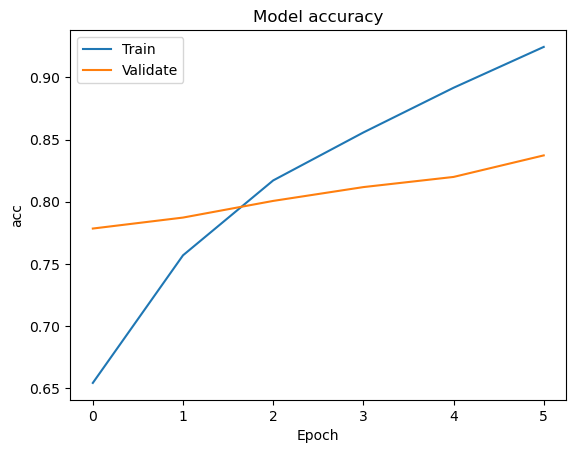

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

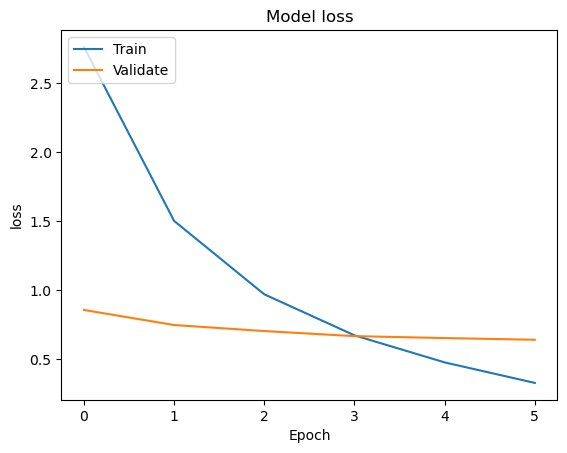

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show() 

In [17]:
scores = model.evaluate(Data_test,Classes_test, verbose=1)
print("VGG16 Score:",scores[1])

120/120 ━━━━━━━━━━━━━━━━━━━━ 55s 439ms/step - accuracy: 0.8219 - loss: 0.6305
VGG16 Score: 0.8303267955780029


In [18]:
predIdxs = model.predict(Data_test,batch_size=32) 
predIdxs=np.argmax(predIdxs,axis=1)

120/120 ━━━━━━━━━━━━━━━━━━━━ 54s 448ms/step


In [19]:
from sklearn.metrics import classification_report,confusion_matrix
testy_res = Classes_test.argmax(axis=1)
CR = classification_report(testy_res, predIdxs)
print(CR)

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1905
           1       0.82      0.84      0.83      1920

    accuracy                           0.83      3825
   macro avg       0.83      0.83      0.83      3825
weighted avg       0.83      0.83      0.83      3825



In [20]:
predictions = model.predict(Data_test)
predicted_labels = np.argmax(predictions, axis=1)
correct_predictions = np.sum(predicted_labels == np.argmax(Classes_test, axis=1))
total_samples = len(Classes_test)
accuracy = correct_predictions / total_samples
print("Test Accuracy:", accuracy)

120/120 ━━━━━━━━━━━━━━━━━━━━ 54s 453ms/step
Test Accuracy: 0.8303267973856209


In [21]:
class_names=['MALE','FEMALE']

In [22]:
import random
def plot_prediction(Data_test, Classes_test, n_images, class_names):
    num_images = len(Data_test)
    random_indices = random.sample(range(num_images), n_images)
    predictions = np.argmax(model.predict(Data_test[random_indices]), axis=1)
    plt.figure(figsize=(14, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(4, 3, i+1)
        plt.imshow(Data_test[idx])
        if predictions[i] == np.argmax(Classes_test[idx]):
            title_color = 'g' 
        else:
            title_color = 'r'
        plt.title(class_names[np.argmax(Classes_test[idx])], color=title_color)
        plt.axis('off')
        
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step


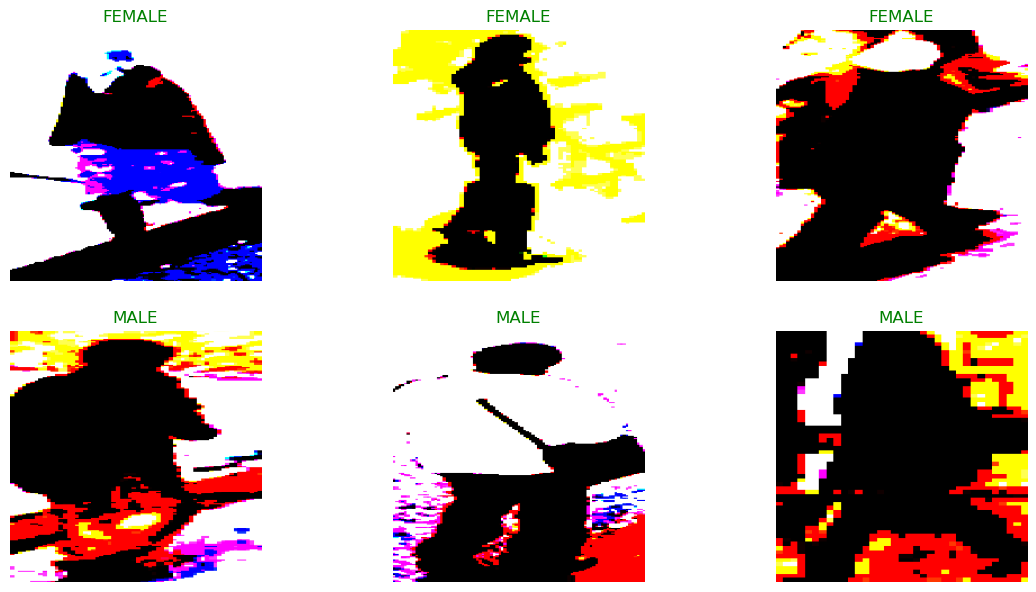

In [23]:
plot_prediction(Data_test, Classes_test, n_images=6, class_names=class_names)

In [14]:
model.save("GenderClassification.h5")